# Task 2: Advanced Model Analysis, Optimization, and Conclusions

### Introduction
In this notebook, we build upon the initial analysis and baseline model created in Part 1, which explored the NYC Property Sales dataset. Our objective in this phase is to enhance the model's performance, address any shortcomings identified during the error analysis, and draw meaningful insights from the improved results.

Reference: https://www.kaggle.com/datasets/new-york-city/nyc-property-sales

Resource: ChatGPT

## Part 0: Load Previous Work
This section loads the cleaned dataset and baseline model from Part 1.

In [3]:
# Import Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

%matplotlib inline

In [5]:
# Define correct column names
column_names = [
    "BOROUGH", "NEIGHBORHOOD", "BUILDING CLASS CATEGORY", 
    "TAX CLASS AT PRESENT", "BLOCK", "LOT", "EASE-MENT", 
    "BUILDING CLASS AT PRESENT", "ADDRESS", "APARTMENT NUMBER", 
    "ZIP CODE", "RESIDENTIAL UNITS", "COMMERCIAL UNITS", 
    "TOTAL UNITS", "LAND SQUARE FEET", "GROSS SQUARE FEET", 
    "YEAR BUILT", "TAX CLASS AT TIME OF SALE", 
    "BUILDING CLASS AT TIME OF SALE", "SALE PRICE", "SALE DATE"
]

# Step 1: Read CSV file with defined column names
file_path = os.path.join(os.getcwd(), "data", "nyc-rolling-sales.csv")
data = pd.read_csv(
    file_path,
    sep=",",
    quotechar='"',
    names=column_names,
    skiprows=1,
    na_values=[" - "],
    on_bad_lines="skip",
    encoding="utf-8"
)

# Step 2: Convert numeric columns to appropriate data types
numeric_columns = [
    "SALE PRICE", "LAND SQUARE FEET", "GROSS SQUARE FEET", 
    "RESIDENTIAL UNITS", "COMMERCIAL UNITS", "TOTAL UNITS"
]
for col in numeric_columns:
    data[col] = pd.to_numeric(data[col], errors="coerce")

# Step 3: Drop rows with invalid or missing `SALE PRICE`
data = data[data["SALE PRICE"] > 0]

# Step 4: Parse and standardize `SALE DATE`
data["SALE DATE"] = pd.to_datetime(data["SALE DATE"], errors="coerce",dayfirst=True)

# Step 5: Drop rows with invalid dates
data = data.dropna(subset=["SALE DATE"])

# Step 6: Reset the index
data = data.reset_index(drop=True)

MAE: 248678.85
RMSE: 347617.84
R²: 0.38


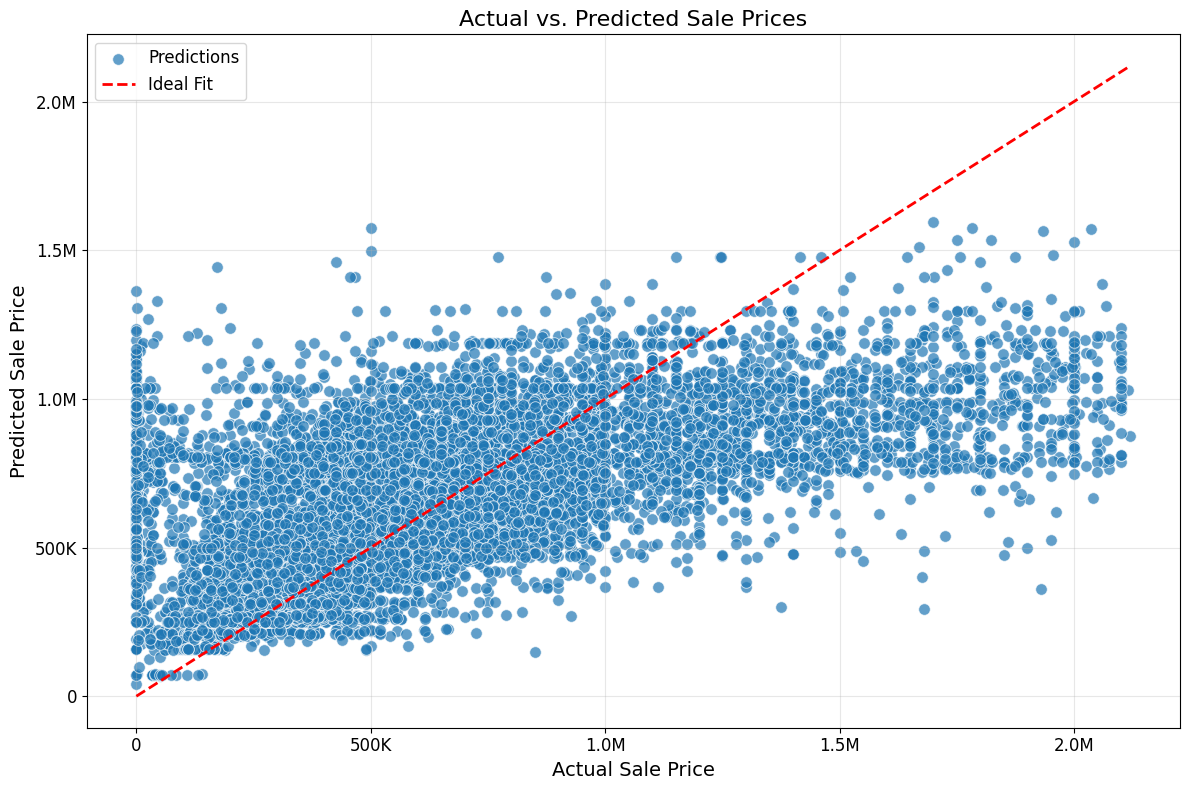

In [6]:
# 1. Import Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# 2. Preprocessing
# Fill missing values for numeric columns
numeric_columns = data.select_dtypes(include=["number"]).columns
for col in numeric_columns:
    data[col] = data[col].fillna(data[col].median())

# Label encode the BOROUGH column
label_encoder = LabelEncoder()  # Initialize the LabelEncoder
data["BOROUGH"] = label_encoder.fit_transform(data["BOROUGH"])  # Apply Label Encoding

# Define features and target variable
features = [
    "BOROUGH", "LAND SQUARE FEET", "TOTAL UNITS", "YEAR BUILT", "GROSS SQUARE FEET"
]
X = data[features]  # Select features
y = data["SALE PRICE"]  # Target variable
# 3. Remove Outliers Using IQR

Q1 = y.quantile(0.25)
Q3 = y.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outlier_filter = (y >= lower_bound) & (y <= upper_bound)
X = X[outlier_filter]
y = y[outlier_filter]



MAE: 248678.85
RMSE: 347617.84
R²: 0.38


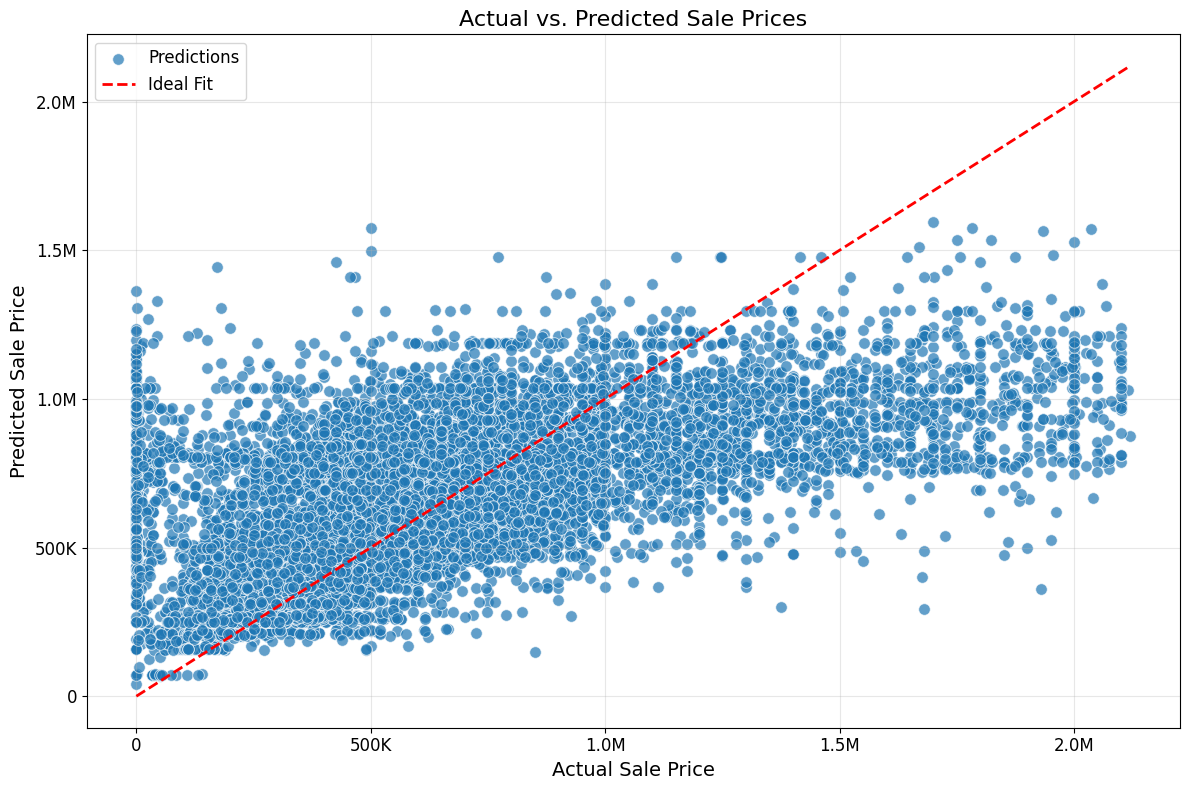

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Train XGBoost Regressor
model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train)

# 5. Predict and Evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

# 6. Actual vs Predicted Sale Prices
# Function to format axis labels as K (thousands) or M (millions)
def format_ticks(value, _):
    if value >= 1_000_000:
        return f'{value/1_000_000:.1f}M'
    elif value >= 10_000:
        return f'{value/1_000:.0f}K'
    else:
        return f'{value:.0f}'

# Plot Actual vs. Predicted Sale Prices
plt.figure(figsize=(12, 8))
sns.scatterplot(x=y_test, y=y_pred, s=70, alpha=0.7, label="Predictions")
plt.plot([y_test.min(), y_test.max()], 
         [y_test.min(), y_test.max()], 
         color='red', linestyle='--', linewidth=2, label="Ideal Fit")

# Add labels and titles
plt.title("Actual vs. Predicted Sale Prices", fontsize=16)
plt.xlabel("Actual Sale Price", fontsize=14)
plt.ylabel("Predicted Sale Price", fontsize=14)

# Format axes with custom tick labels
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_ticks))
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_ticks))

# Improve layout and add grid
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

## Part 1: Error Analysis Conclusions and Work Plan

### Key Factors Behind Errors
* Outlier Cases: Extreme sale prices or unusual features, such as rare building types or unique property characteristics, create significant prediction challenges. These cases distort the model's learning.
* Sparse Data: Limited examples in certain categories (e.g., properties in underrepresented boroughs) reduce the model's ability to generalize.
* Quality Issues: Incorrect or inconsistent records in the dataset introduce noise, affecting the model's predictions.
* Missing Influential Variables: Lack of data on critical factors like renovation status, neighborhood trends, or market demand diminishes model accuracy.

### Overestimations and Underestimations
* Causes: Skewed data distributions and missing features lead to systematic overestimation or underestimation. Unique property traits or neighborhood trends unaccounted for in the model result in inaccuracies.
* Residual Analysis: Residuals show a slightly left-skewed distribution, indicating a minor bias towards underestimations. A mean residual close to zero suggests that, on average, predictions are unbiased.

### Correlation and Feature Impact
* Heatmap Insights: Weak correlations between most features and the target variable (SALE PRICE) suggest errors aren't tied to a single feature. A notable correlation of 0.78 between some variables hints at multicollinearity, which might confuse the model's interpretation.
* Potential Sabotages: Misreported sale prices (e.g., for tax purposes) and extreme values disproportionately influence the model. Highly represented categories, such as specific boroughs, can skew overall statistics and predictions.


### Work Plan
* Handle Outliers: Detect and cap or remove extreme values in SALE PRICE and other numerical features.
* Enhance Data Quality: Impute missing values and resolve inconsistent or incorrect records.
* Feature Engineering: Create new features (e.g., price per square foot) and transform skewed ones to improve predictive power.
* Balance the Dataset: Use resampling techniques or class weights to address imbalances in categories like boroughs or price ranges.
* Improve Modeling: Optimize model performance through hyperparameter tuning and ensemble methods.
* Analyze and Interpret: Use tools like SHAP, residual plots, and correlation analysis to understand model errors and refine predictions.

## Part 2: Improving Model Performance

Before SMOTE: SALE PRICE
10.0         615
650000.0     350
450000.0     339
550000.0     324
600000.0     324
            ... 
812000.0       3
1909218.0      3
972500.0       3
957000.0       3
843000.0       3
Name: count, Length: 1560, dtype: int64
After SMOTE: SALE PRICE
1093600.0    615
435000.0     615
262000.0     615
1100000.0    615
220000.0     615
            ... 
495000.0     615
615000.0     615
288990.0     615
595000.0     615
490000.0     615
Name: count, Length: 1560, dtype: int64
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 2/5] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=400, reg_alpha=1, reg_lambda=2.5, scale_pos_weight=1.2, subsample=0.9;, score=-153307.693 total time=  38.5s
[CV 1/5] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.01, max_depth=3, min_child_weight=3, n_estimators=400, reg_alpha=1, reg_lambda=2.5, scale_pos_weight=1.2, subsample=0.9;, score=-341774.648 total time=

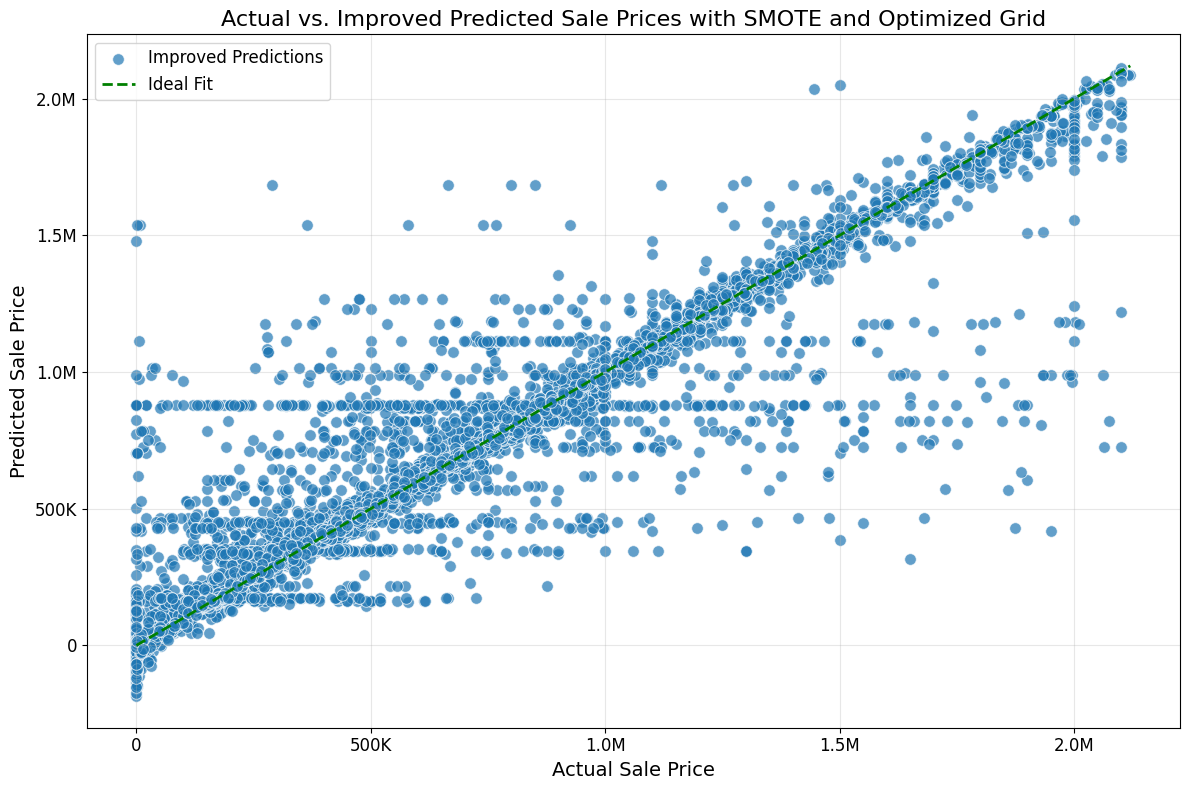

In [19]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import FunctionTransformer
from imblearn.over_sampling import SMOTE

# Feature Engineering: Create new features and transform existing ones
# 1. Age of the building
current_year = 2025  # Adjust based on the current year
data["BUILDING_AGE"] = current_year - data["YEAR BUILT"]
data["BUILDING_AGE"] = data["BUILDING_AGE"].apply(lambda x: x if x >= 0 else 0)  # Ensure non-negative ages

# 2. Price per gross square foot
# Avoid dividing by zero
data["PRICE_PER_SQFT"] = data["SALE PRICE"] / data["GROSS SQUARE FEET"].replace(0, np.nan)
data["PRICE_PER_SQFT"] = data["PRICE_PER_SQFT"].fillna(0)

# 3. Log transformation for skewed features
log_transformer = FunctionTransformer(np.log1p, validate=True)
data["LOG_LAND_SQFT"] = log_transformer.transform(data["LAND SQUARE FEET"].values.reshape(-1, 1))
data["LOG_GROSS_SQFT"] = log_transformer.transform(data["GROSS SQUARE FEET"].values.reshape(-1, 1))

# Define updated features
features = [
    "BOROUGH", "LOG_LAND_SQFT", "LOG_GROSS_SQFT", "TOTAL UNITS", "BUILDING_AGE", "PRICE_PER_SQFT"
]
X = data[features]
y = data["SALE PRICE"]

# Remove outliers using IQR
Q1 = y.quantile(0.25)
Q3 = y.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outlier_filter = (y >= lower_bound) & (y <= upper_bound)
X = X[outlier_filter]
y = y[outlier_filter]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ensure there are no categories with only one sample to avoid SMOTE errors
sample_counts = y_train.value_counts()
min_samples_required = 3
valid_indices = y_train.index[y_train.map(sample_counts) >= min_samples_required]
X_train = X_train.loc[valid_indices]
y_train = y_train.loc[valid_indices]

# Apply SMOTE with reduced k_neighbors
smote = SMOTE(random_state=42, k_neighbors=1)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"Before SMOTE: {y_train.value_counts()}")
print(f"After SMOTE: {y_train_balanced.value_counts()}")

# Optimized Hyperparameter Tuning Grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.03, 0.05, 0.07, 0.1],
    'max_depth': [3, 4, 5, 6, 7, 9],
    'min_child_weight': [1, 2, 3, 4, 5],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.01, 0.1, 0.5, 1],
    'reg_lambda': [0.5, 1, 1.5, 2, 2.5],
    'gamma': [0, 0.1, 0.2, 0.3],
    'scale_pos_weight': [1, 1.2, 1.5]
}

# Perform Randomized Search with Updated Parameter Grid
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    scoring='neg_mean_absolute_error',
    n_iter=100,  # Increased iterations for better exploration
    cv=5,  # Increased cross-validation folds for more stability
    verbose=3,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_balanced, y_train_balanced)

# Best parameters and model evaluation
print("Best hyperparameters:", random_search.best_params_)

best_model = random_search.best_estimator_
y_pred_best = best_model.predict(X_test)

mae_best = mean_absolute_error(y_test, y_pred_best)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2_best = r2_score(y_test, y_pred_best)
print(f"MAE after tuning, feature engineering, and balancing: {mae_best:.2f}")
print(f"RMSE after tuning, feature engineering, and balancing: {rmse_best:.2f}")
print(f"R² after tuning, feature engineering, and balancing: {r2_best:.2f}")

# Plot improved predictions
plt.figure(figsize=(12, 8))
sns.scatterplot(x=y_test, y=y_pred_best, s=70, alpha=0.7, label="Improved Predictions")
plt.plot([y_test.min(), y_test.max()], 
         [y_test.min(), y_test.max()], 
         color='green', linestyle='--', linewidth=2, label="Ideal Fit")

plt.title("Actual vs. Improved Predicted Sale Prices with SMOTE and Optimized Grid", fontsize=16)
plt.xlabel("Actual Sale Price", fontsize=14)
plt.ylabel("Predicted Sale Price", fontsize=14)
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_ticks))
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_ticks))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


## Part 3: Analyzing the Improved Model

In [48]:
# Placeholder for feature importance and model performance evaluation

## Part 4: Drawing Conclusions and Creative Applications

In [49]:
# Placeholder for data insights and applications